In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [48]:
c1 = 0.5 # now
c2 = 0.75 # in september
b = 1 # after september
h = 0.1

## Solving a single-stage problem (exercise a)

In [16]:
c = c1 # let's consider the situation in exercises (a) and (b)

def cost(y, A, B):
    return b * (A+B) / 2 + (c-b) * y - (b+h) * (A-y)*(A-y) / (2*(A-B))

# formula (1.6) in Shapiro's tutorial
def solve_second_exact(A, B):
    kappa = (b - c) / (b + h)
    y = A * (1-kappa) + B * kappa
    return y, cost(y, A, B)

# problem (2.5) in Shapiro's tutorial
def solve_second_MC(A, B, K):
    scenarios = np.random.uniform(low=A, high=B, size=K)

    y = cp.Variable(1)
    t = cp.Variable(K)
    objective = cp.Minimize(cp.sum(t) / K)
    constraints = [y >= 0]

    for i, dk in enumerate(scenarios):
        constraints.append((c-b) * y - t[i] <= -b * dk)
        constraints.append((c+h) * y - t[i] <= h * dk)
    
    prob = cp.Problem(objective, constraints)
    prob.solve()

    candidate = y.value[0]
    return candidate, prob.value

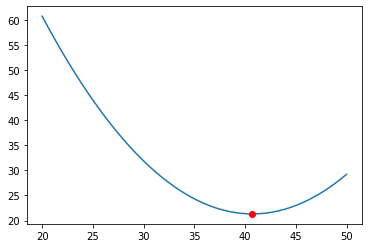

In [17]:
x = np.linspace(20, 50)
plt.plot(x, cost(x, 38, 44))
y, cst = solve_second_exact(38, 44)
plt.plot(y, cst, 'ro');

In [19]:
y1, cost1 = solve_second_exact(38, 44)
y2, cost2 = solve_second_MC(38, 44, 1000)
print(f'exact solution: {y1}, with cost: {cost1}')
print(f'MC solution: {y2}, with cost: {cost2}')

exact solution: 40.72727272727273, with cost: 21.318181818181817
MC solution: 40.7131847809286, with cost: 21.319212259854805


## Solving the two-stage version (exercise c)

### Monte Carlo for first stage only

We first express $Q(x, \xi)$ in terms of $x,A,B$.

In [87]:
# for A <= x <= B
def d2(A, B):
    return (b+h) / (2*(B-A))
def d1(A, B):
    return (A/(A-B)) * (b+h) -c2 + c1
def d0(A, B):
    return ((b+h)*A*A) / (2 * (B-A))

# for x > B
Bd1 = b + h -c2 + c1
def Bd0(A, B):
    return (b+h) * ((B-A) / 2 - B)

# constant term in Q
def C(A, B):
    k = (b-c2)/(b+h)
    l = A + k*(B-A)
    return b*(A+B)/2 + (c2 - b) * l + (b+h)*(B - A)*k/2

# we define the cost function piecewise
def Q(x, A, B):
    if A <= x <= B:
        return d2(A, B) * x*x + d1(A, B) * x + d0(A, B) + C(A,B)
    elif x > B:
        return Bd1 * x + Bd0(A, B) + C(A,B)
    else:
        return (-c2 + c1) *x + C(A,B)

optimal x: 39.36363636363636


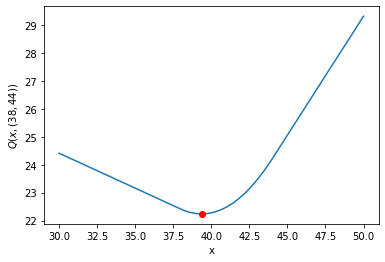

In [104]:
# solve an example for given A, B
A = 38
B = 44
xs = np.linspace(30, 50)
y = [Q(x, A, B) for x in xs]

def x_opt(d1, d2):
    return -d1/(2*d2) # extreme point of parabola

s = x_opt(d1(A, B), d2(A, B))

plt.plot(xs, y)
plt.plot(s, Q(s, A, B), 'ro')
plt.xlabel('x'); plt.ylabel(r'$Q(x,(38,44))$')
plt.savefig('example_Q.pdf')
print(f'optimal x: {s}')

We can now perform a straightforward grid search on $x$ to find a value close to the optimum.

solution x=39.8799, with cost=21.4021
solution x=39.8619, with cost=21.3486
solution x=39.7057, with cost=21.3203
solution x=39.7598, with cost=21.3728
solution x=39.7838, with cost=21.3707


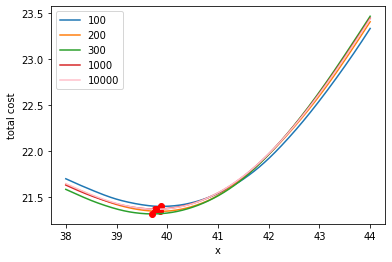

In [134]:
def get_Q(xs, N, low=38, high=44):
    # samples ksi_i = (A_i, B_i) = (min(U_1, U_2), max(U_1, U_2)), where U_i ~ Uni[38, 44]
    bounds = np.sort(np.random.uniform(low=low, high=high, size=(N,2)), axis=1)
    As, Bs = bounds[:,0], bounds[:,1]

    def objective(x):
        res = 0
        for A, B in zip(As, Bs):
            res += Q(x, A, B)
        return res / N

    return [objective(x) for x in xs]

def find_solution(N, low=38, high=44):
    xs =  np.linspace(low, high, num=1000)
    ys = get_Q(xs, N, low=low, high=high)
    args = {'color': 'pink'} if N > 1000 else {} # default color is hard to distinguish from the first
    plt.plot(xs, ys, label=N, **args)
    s = xs[np.argmin(ys)]
    cst = np.min(ys)
    plt.plot(s, cst, 'ro')
    plt.xlabel('x')
    plt.ylabel('total cost')
    print(f'solution x={s:.4f}, with cost={cst:.4f}')

find_solution(100)
find_solution(200)
find_solution(300)
find_solution(1000)
find_solution(10000)
plt.legend()
plt.savefig('MC_grid.pdf')

## Value of storage unit (exercise d)